# 한국어 챗봇 프로젝트

  - 공백, 특수문자 전처리
  - 토크나이징, 병렬데이터 구축
  - 안정적인 학습 수렴
  - 맥락에 맞는 한국어 문장 반환

 ### 적용해볼 만한 것들
 
 - 학습 에포크 조정하기
 - 러닝커브 조정하기
 - 토크나이저, 임베딩 튜닝
 - 샘플링 온도

In [1]:
import tensorflow as tf
print(tf.__version__)
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt


2.6.0


In [2]:
os.system("mkdir -p ~/aiffel/transformer_chatbot/data/")
os.system("ln -s ~/data/* ~/aiffel/transformer_chatbot/data/")

0

In [5]:
import pandas as pd
d_path = "/aiffel/aiffel/transformer_chatbot/data/"
raw_data = pd.read_csv(d_path+"ChatbotData .csv")
raw_data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [118]:
# 사용할 샘플의 최대 개수; 한국어 데이터의 규모가 작으므로 전체 사용
MAX_SAMPLES = 50000
print(MAX_SAMPLES)

50000


In [102]:
# 전처리 함수
def preprocess_sentence(sentence):
  # 입력받은 sentence를 소문자로 변경하고 양쪽 공백을 제거; 한국어 불필요
  # sentence = sentence.lower()
  # sentence = sentence.strip()

  # (유니코드 문자열 ".", "?", "!", ",")를 제외한 모든 문자를 공백으로 대체
  # 한글은 유니코드에 포함되어 있고 낱소리만 쓰인 문자열도 포함됨
  sentence = re.sub(r'([^\w?!,])', " ", sentence)
  sentence = sentence.strip()
  
  # 구두점(punctuation)을 토큰으로 인식하도록 단어와의 사이에 공백
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = sentence.strip()
  sentence = re.sub(r'[" "]+', " ", sentence)

  return sentence

In [130]:
# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장
questions = [preprocess_sentence(s) for s in  raw_data["Q"]]
answers = [preprocess_sentence(s) for s in  raw_data["A"]]
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [113]:
# 닿소리이나 홀소리가 따로 쓰인 것도 무사히 포함된 것을 확인
print('전처리 후의 {}번째 질문 샘플: {}'.format((i:=1153)+1,questions[i]))
print('전처리 후의 {}번째 답변 샘플: {}'.format(i+2, answers[i]))

print('전처리 후의 {}번째 질문 샘플: {}'.format((i:=2104)+1,questions[i]))
print('전처리 후의 {}번째 답변 샘플: {}'.format(i+2, answers[i]))

전처리 후의 1154번째 질문 샘플: 단둘이는 처음 만나는 날ㅋㅋ
전처리 후의 1155번째 답변 샘플: 서로를 아는 좋은 기회가 되겠네요
전처리 후의 2105번째 질문 샘플: 보일러 틀고 나갔어ㅠㅠ
전처리 후의 2106번째 답변 샘플: 이번달 난방비가 많이 나오겠네요


In [114]:
# 따옴표 같은 기타 문장부호 탈락
print('전처리 후의 {}번째 질문 샘플: {}'.format((i:=6515)+1,questions[i]))
print('전처리 후의 {}번째 답변 샘플: {}'.format(i+1, answers[i]))

전처리 후의 6516번째 질문 샘플: 부르고 , 찾고 , 기도해봐도 결국은 이미 끝난 사이다
전처리 후의 6516번째 답변 샘플: 언젠간 올 이별이었을까요


In [115]:
characters = set(c for s in questions + answers for c in s)
# print(len(characters))
print(characters)

{'턴', '썩', '뿅', '찌', '듯', '육', '펼', '샜', '학', '뛰', '왓', '톤', '캄', '볼', '곤', '승', '침', '껄', '져', '6', '혐', '퓨', '표', '피', '텁', '뱄', '걸', '트', '골', '와', '누', '축', '봅', '쿨', '험', '깝', '런', 'N', '찢', '딪', '함', '펨', '귈', '낀', '상', '랖', '록', '핑', '광', '거', '합', '나', '롯', '난', '풋', '널', '얇', '진', '위', '버', '촉', '싱', '퉜', '찼', '밌', '묘', '러', '닮', '타', '큰', '찔', '확', '챘', '텀', '옷', '실', '심', '부', '미', '종', '몸', '켓', '홧', '잊', '묵', '질', '님', '짓', '늦', '콧', '괜', '칫', '겟', '능', '죠', '폼', '땜', '령', '냈', '렛', '릅', '뜰', '엠', '맡', '딸', '뒤', '락', '후', '룸', '념', '쿼', 'ㅋ', '멘', '존', '딛', '씁', '쏟', '완', '즘', '딜', '됩', '펭', '갠', '렁', '뀔', '웁', '엇', '써', '롤', '놈', '봐', '양', '복', '녁', '컴', '윗', '컨', 'S', '쩔', '렵', '새', '쉬', '쪘', '댜', '춰', '닝', '짠', '짚', '루', '봤', '중', '톱', ' ', '식', 'ㅜ', '깊', '찝', '헷', '쎌', '차', '독', '여', '쭈', '크', '들', '르', '앗', '께', '옛', '눈', '핏', '소', '남', '박', '꺽', '힙', '급', '꿀', '년', '힌', '눌', '끊', '땠', '구', '흰', '뭘', '노', '된', '렸', '엊', '찹', '매', '빠', '느', '왕', '곱', '덮', '뜩', '룰', '흑',

In [15]:
tokens = set(w for s in questions + answers for w in s.split())
print(len(tokens))

20684


In [18]:
max_len = max(len(s.split()) for s in questions + answers)
print(max_len)

22


### 데이터 전처리

In [ ]:
import tensorflow_datasets as tfds

In [131]:
# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
# target_vocab_size는 위의 토큰 수와 대략적으로 비슷한 20000개로 설정 
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
                                questions + answers, target_vocab_size=20000)

In [132]:
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [21935]
END_TOKEN의 번호 : [21936]


In [133]:
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

21937


In [141]:
tokenizer.decode([0])

''

In [142]:
tokenizer.decode([1])

' ?'

In [143]:
tokenizer.decode([2])

'거예요'

In [144]:
tokenizer.decode([3])

'수 '

In [134]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5206, 1368, 2623]
정수 인코딩 후의 21번째 답변 샘플: [1303, 8721, 5, 6212]


In [135]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
# 입력 데이타 중 가장 긴 문장의 길이가 22 이므로 22로 설정
MAX_LENGTH = 22
print(MAX_LENGTH)

22


In [124]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
                  tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
                  tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs

In [125]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 21937
필터링 후의 질문 샘플 개수: 11821
필터링 후의 답변 샘플 개수: 11821


In [126]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

### 모델 정의 및 초기화

In [30]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [31]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

### 멀티헤드 어텐션

In [32]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs

In [33]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [34]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

In [37]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [38]:
# 레이어 스펙을 입력받아 인코더 레이어를 반환하는 함수
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [39]:
# 디코더 하나의 레이어를 함수로 구현.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [40]:
# 레이어 스펙을 입력받아 디코더 레이어를 반환하는 함수
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [41]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # create_padding_mask 함수를 인코더 입력에 맵핑
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # create_look_ahead_mask 함수를 디코더 입력에 맵핑
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # create_padding_mask 함수를 두 번째 어텐션 블록입력에 맵핑
  # 인코더에서 디코더로 들어오는 벡터들을 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [42]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    6670080     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [43]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

In [44]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

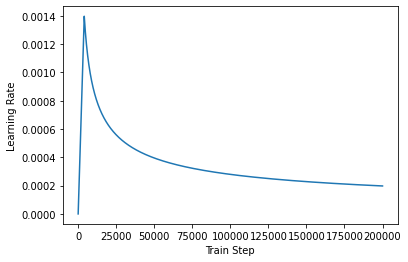

In [45]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [46]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [82]:
EPOCHS = 30
history = model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/30
185/185 [==============================] - 12s 66ms/step - loss: 0.0942 - accuracy: 0.2079
Epoch 2/30
185/185 [==============================] - 12s 66ms/step - loss: 0.0703 - accuracy: 0.2118
Epoch 3/30
185/185 [==============================] - 12s 66ms/step - loss: 0.0555 - accuracy: 0.2142
Epoch 4/30
185/185 [==============================] - 12s 66ms/step - loss: 0.0468 - accuracy: 0.2151
Epoch 5/30
185/185 [==============================] - 12s 67ms/step - loss: 0.0450 - accuracy: 0.2153
Epoch 6/30
185/185 [==============================] - 12s 67ms/step - loss: 0.0408 - accuracy: 0.2161
Epoch 7/30
185/185 [==============================] - 12s 66ms/step - loss: 0.0366 - accuracy: 0.2168
Epoch 8/30
185/185 [==============================] - 12s 67ms/step - loss: 0.0323 - accuracy: 0.2179
Epoch 9/30
185/185 [==============================] - 12s 66ms/step - loss: 0.0285 - accuracy: 0.2184
Epoch 10/30
185/185 [==============================] - 12s 67ms/step - loss: 0.025

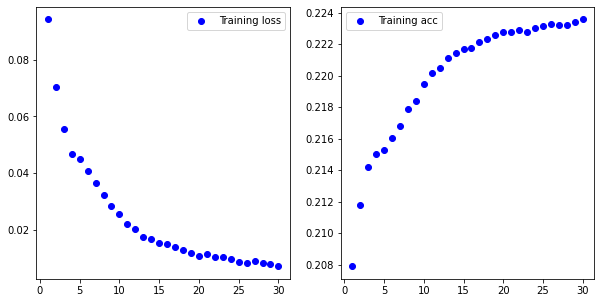

In [83]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10,5))
history_dict = history.history
loss_values = history_dict["loss"]
# val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
axes[0].plot(epochs, loss_values, "bo", label="Training loss",)
# axes[0].plot(epochs, val_loss_values, "b", label="Validation loss",)
axes[0].legend()

acc = history_dict["accuracy"]
# val_acc = history_dict["val_accuracy"]
axes[1].plot(epochs, acc, "bo", label="Training acc",)
# axes[1].plot(epochs, val_acc, "b", label="Validation acc",)
axes[1].legend()
plt.show()

### 모델 테스트

In [84]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)
print("슝=3")

슝=3


In [85]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence
print("슝=3")

슝=3


In [86]:
sentence_generation('어디 있었어?')

입력 : 어디 있었어?
출력 : 이젠 마음의 정리를 기억을 좋겠어요


'이젠 마음의 정리를 기억을 좋겠어요'

In [87]:
sentence_generation("완전 대박이네")

입력 : 완전 대박이네
출력 : 마음이 좀 후련해지길 바랄게요


'마음이 좀 후련해지길 바랄게요'

In [88]:
sentence_generation("1지망 학교 떨어졌는데 3박 4일 놀러가도 될까?")

입력 : 1지망 학교 떨어졌는데 3박 4일 놀러가도 될까?
출력 : 위로해 드립니다


'위로해 드립니다'

In [89]:
sentence_generation("오늘 나 완전 기분 꿀꿀한데 저녁 뭐 먹을까")

입력 : 오늘 나 완전 기분 꿀꿀한데 저녁 뭐 먹을까
출력 : 아예 알려고 하지 않는 게 편한 거 같아요


'아예 알려고 하지 않는 게 편한 거 같아요'

In [90]:
sentence_generation("오늘나완전기분꿀꿀한데저녁뭐먹을까")

입력 : 오늘나완전기분꿀꿀한데저녁뭐먹을까
출력 : 그것만큼 마음 아픈 일도 없겠네요


'그것만큼 마음 아픈 일도 없겠네요'

In [91]:
sentence_generation("오늘나완전기분꿀꿀")

입력 : 오늘나완전기분꿀꿀
출력 : 연애 초기 데이트를 해보면서 극복해보세요


'연애 초기 데이트를 해보면서 극복해보세요'

In [92]:
sentence_generation("오늘 나랑 밥 먹을래?")

입력 : 오늘 나랑 밥 먹을래?
출력 : 저는 좋아요


'저는 좋아요'

In [93]:
sentence_generation("오늘 나랑 lunch 먹을래?")

입력 : 오늘 나랑 lunch 먹을래?
출력 : 직접 물어보는게 정확할 거예요


'직접 물어보는게 정확할 거예요'

In [94]:
sentence_generation("오늘 나랑 3 먹을래?")

입력 : 오늘 나랑 3 먹을래?
출력 : 큰 결심이네요 꼭 성공할 거예요


'큰 결심이네요 꼭 성공할 거예요'

In [95]:
sentence_generation("오늘 나랑 PPL 갈래?")

입력 : 오늘 나랑 PPL 갈래?
출력 : 보통 사랑은 그렇죠


'보통 사랑은 그렇죠'

In [96]:
sentence_generation("오늘 너 좀 예쁘네")

입력 : 오늘 너 좀 예쁘네
출력 : 직접 물어보는 게 좋을 것 같아요


'직접 물어보는 게 좋을 것 같아요'

In [97]:
sentence_generation("오늴 니 쫌 이쁘네")

입력 : 오늴 니 쫌 이쁘네
출력 : 좀 더 지켜보는 게 좋겠어요


'좀 더 지켜보는 게 좋겠어요'

In [98]:
sentence_generation("썸")

입력 : 썸
출력 : 귀찮아서 친구랑 하루 종일 연락 안해요


'귀찮아서 친구랑 하루 종일 연락 안해요'